In [1]:
# %pip install tensorflow_probability 

# CNN a GM


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt


datos


In [ ]:
# 02_main.ipynb
from grav_lens import get_datasets
from grav_lens.models import test_model_image

import os 

home_data = os.path.join("..","data")
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=32*4, 
    home=home_data)

Modelo Gaussiano
Toma los parametros y construye la imagen

In [91]:
class GaussianImageLayer(tf.keras.layers.Layer):
    def __init__(self, img_size=64, Ng=10, sigma_penalty_weight=0.01, c_pi_penalty_weight=0.01, **kwargs):
        super(GaussianImageLayer, self).__init__(**kwargs) 
        self.img_size = img_size  # Tamaño de la imagen generada
        self.Ng = Ng  # Número de Gaussianas
        self.sigma_penalty_weight = sigma_penalty_weight  # Peso de la penalización sobre sigma
        self.c_pi_penalty_weight = c_pi_penalty_weight  # Peso de la penalización sobre c_pi

    def call(self, flat_tensor):
        """Construcción de la imagen con múltiples Gaussianas a partir del tensor plano."""
        batch_size = tf.shape(flat_tensor)[0]
        
        # Ahora Ng es un parámetro fijo pasado al constructor
        Ng = self.Ng

        # Extraer c_pi, mu_x, mu_y, sigma_x, sigma_y
        c_pi = flat_tensor[:, :Ng]  # Coeficientes de mezcla
        mu_x = flat_tensor[:, Ng:2*Ng]  # Media en x
        mu_y = flat_tensor[:, 2*Ng:3*Ng]  # Media en y
        sigma_x = tf.abs(flat_tensor[:, 3*Ng:4*Ng]) + 0.1  # Desviación estándar en x (mínimo de 0.1)
        sigma_y = tf.abs(flat_tensor[:, 4*Ng:]) + 0.1  # Desviación estándar en y (mínimo de 0.1)

        # Añadir penalización de sigma en la loss (L2 regularization para mantener los valores pequeños)
        self.add_loss(self.sigma_penalty_weight * tf.reduce_sum(tf.square(sigma_x) + tf.square(sigma_y)))

        # Añadir penalización de c_pi en la loss (L2 regularization para mantener los valores de c_pi cercanos a 0)
        self.add_loss(self.c_pi_penalty_weight * tf.reduce_sum(tf.square(c_pi)))

        # Normalizar mu_x y mu_y al rango de la grilla [-1, 1]
        mu_x = mu_x * 2 - 1  # Transformar de [0, 1] a [-1, 1]
        mu_y = mu_y * 2 - 1  # Transformar de [0, 1] a [-1, 1]

        # Crear una grilla de coordenadas (img_size x img_size)
        x = tf.linspace(-1.0, 1.0, self.img_size)
        y = tf.linspace(-1.0, 1.0, self.img_size)
        X, Y = tf.meshgrid(x, y)  # Crear grilla de coordenadas
        coords = tf.stack([X, Y], axis=-1)  # Combinar coordenadas (img_size, img_size, 2)

        # Expandir dimensiones para batch y Ng
        coords = tf.reshape(coords, (1, self.img_size, self.img_size, 2))  # (1, img_size, img_size, 2)
        coords = tf.tile(coords, [batch_size, 1, 1, 1])  # (batch_size, img_size, img_size, 2)

        # Inicializar la imagen final en ceros
        final_image = tf.zeros((batch_size, self.img_size, self.img_size), dtype=tf.float32)

        # Iterar sobre el número de Gaussianas (Ng)
        for i in range(Ng):
            # Obtener las medias y desviaciones para la Gaussiana i
            mu = tf.stack([mu_x[:, i], mu_y[:, i]], axis=-1)  # (batch_size, 2)
            sigma = tf.stack([sigma_x[:, i], sigma_y[:, i]], axis=-1)  # (batch_size, 2)

            # Expandir las dimensiones de mu y sigma para que coincidan con las coordenadas de la imagen
            mu = tf.expand_dims(mu, axis=1)  # (batch_size, 1, 2)
            mu = tf.expand_dims(mu, axis=1)  # (batch_size, 1, 1, 2)
            sigma = tf.expand_dims(sigma, axis=1)  # (batch_size, 1, 2)
            sigma = tf.expand_dims(sigma, axis=1)  # (batch_size, 1, 1, 2)

            # Crear una distribución normal multivariada para cada batch y Gaussiana
            mvn = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
            
            # Calcular las probabilidades en las coordenadas de la imagen
            gaussians = mvn.prob(coords)  # (batch_size, img_size, img_size)
            
            # Ponderar cada Gaussiana por c_pi (ajustar dimensiones para que coincidan)
            gaussians_weighted = gaussians * tf.expand_dims(tf.expand_dims(c_pi[:, i], axis=-1), axis=-1)

            # Sumar la Gaussiana ponderada a la imagen final
            final_image += gaussians_weighted

        # Expandir las dimensiones de la imagen final para que sea (batch_size, img_size, img_size, 1)
        return tf.expand_dims(final_image, axis=-1)

    def compute_output_shape(self, input_shape):
        # Definir la forma de salida, que será (batch_size, img_size, img_size, 1)
        return (input_shape[0], self.img_size, self.img_size, 1)


shape out: (4, 64, 64, 1)


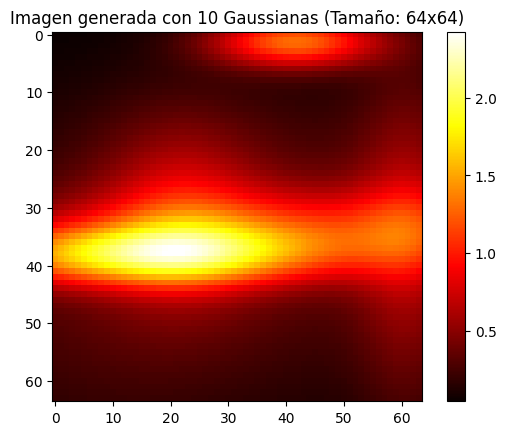

In [92]:

# Probar la capa GaussianImageLayer
def test_gaussian_image_layer():
	batch_size = 4
	Ng = 10  # Número de Gaussianas
	img_size = 64  # Tamaño de la imagen

	# Crear un tensor plano simulado de salida de una CNN (batch_size, 5*Ng)
	flat_tensor = tf.random.uniform(shape=(batch_size, 5*Ng), minval=0.0, maxval=1.0)

	# Instanciar la capa personalizada
	gaussian_layer = GaussianImageLayer(img_size=img_size)

	# Ejecutar la capa sobre el tensor plano
	output_image = gaussian_layer(flat_tensor)
	print("shape out:",output_image.shape)

	# Mostrar la imagen generada para el primer batch
	plt.imshow(output_image[0, :, :, 0], cmap='hot')
	plt.colorbar()
	plt.title(f"Imagen generada con {Ng} Gaussianas (Tamaño: {img_size}x{img_size})")
	plt.show()

# Ejecutar el test
test_gaussian_image_layer()


# Construccion del modelo

In [27]:
from grav_lens import metrics

In [93]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(hyperparams):
	"""
	Función para construir un modelo CNN secuencial con hiperparámetros ajustables a través de un diccionario.
	
	Parámetros:
	- hyperparams: Diccionario con los hiperparámetros del modelo.
	
	Retorna:
	- Un modelo CNN construido con los hiperparámetros especificados.
	"""
	
	img_size = hyperparams['img_size']
	Ng = hyperparams['Ng']
	num_conv_layers = hyperparams['num_conv_layers']
	conv_filters = hyperparams['conv_filters']
	kernel_size = hyperparams['kernel_size']
	dense_units = hyperparams['dense_units']
	num_dense_layers = hyperparams['num_dense_layers']
	activation = hyperparams['activation']
	output_activation = hyperparams['output_activation']
	learning_rate = hyperparams['learning_rate']
	

	input_layer = tf.keras.layers.Input(shape=(128, 128, 3))

	initializer = tf.keras.initializers.GlorotNormal()
	x = layers.Conv2D(conv_filters* (Ng//5), kernel_size, 
		activation=activation, padding='same', kernel_initializer=initializer)(input_layer)

	# Capas convolucionales hidden 
	for _ in range(num_conv_layers):
		x = layers.Conv2D(conv_filters*4, kernel_size, 
			activation=activation, padding='same', kernel_initializer=initializer)(x)
		x = layers.MaxPooling2D(pool_size=(2, 2))(x)
	
	# Aplanar la salida de las convolucionales
	x = layers.Flatten()(x)

	# Capas densas ocultas
	for _ in range(num_dense_layers):
		x = layers.Dense(dense_units, activation=activation, kernel_initializer=initializer)(x)
	
	# Capa de salida para generar el vector plano
	output_units = 5 * Ng  # 5 parámetros por cada Gaussiana
	x = layers.Dense(output_units, activation=output_activation, kernel_initializer=initializer)(x)

	out_img = GaussianImageLayer(img_size=128, Ng=Ng, name='out_img')(x)
	
	model = tf.keras.models.Model(inputs=input_layer, 
		outputs=[out_img, out_img] )

	optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


	model.compile(optimizer=optimizer, 
				loss= ['mse', metrics.WMAPE],
				metrics={'out_img': [metrics.DICEE, metrics.WMAPE]})


	return model

# Hiperparámetros como un diccionario
hyperparams = {
	'img_size': 128,               # Tamaño de la imagen de entrada
	'Ng': 10,                     # Número de Gaussianas (esto afecta el tamaño de salida)
	'num_conv_layers': 4,         # Número de capas convolucionales
	'conv_filters': 32,           # Número de filtros en cada capa convolucional
	'kernel_size': (3, 3),        # Tamaño del kernel
	'dense_units': 128,           # Número de unidades en las capas densas
	'num_dense_layers': 2,        # Número de capas densas
	'activation': 'tanh',         # Función de activación en las capas
	'output_activation': 'sigmoid',    # Sin activación final (los valores pueden ser negativos o positivos)
	'learning_rate': 0.0001        # Tasa de aprendizaje
}

# Crear el modelo utilizando el diccionario de hiperparámetros
cnn_model = create_cnn_model(hyperparams)

# Resumen del modelo
cnn_model.summary()


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_img (GaussianImageLayer)    │ (None, 128, 128, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,122 (1.23 MB)

 Trainable params: 323,122 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:

# Entrenamiento del modelo
# Puedes entrenar el modelo con tus datos aquí

history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=True)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 4.1283 - out_img_dicee: 0.5609 - out_img_wmape: 361.0442 - val_loss: 2.9877 - val_out_img_dicee: 0.4448 - val_out_img_wmape: 166.5138
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 2.6997 - out_img_dicee: 0.5544 - out_img_wmape: 228.4275 - val_loss: 1.7689 - val_out_img_dicee: 0.4137 - val_out_img_wmape: 119.4500
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 1.6388 - out_img_dicee: 0.5410 - out_img_wmape: 140.4834 - val_loss: 1.2094 - val_out_img_dicee: 0.4419 - val_out_img_wmape: 78.2560
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 1.1622 - out_img_dicee: 0.5446 - out_img_wmape: 129.4254 - val_loss: 0.9447 - val_out_img_dicee: 0.4264 - val_out_img_wmape: 73.7796
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.9209 - out_img_dicee: 0.5469 - out_img_wmape: 111.7909 - val_loss: 0.7741 - val_out_img_dicee: 0.4418 - val_out_img_wmape: 72.9666


## Ver history

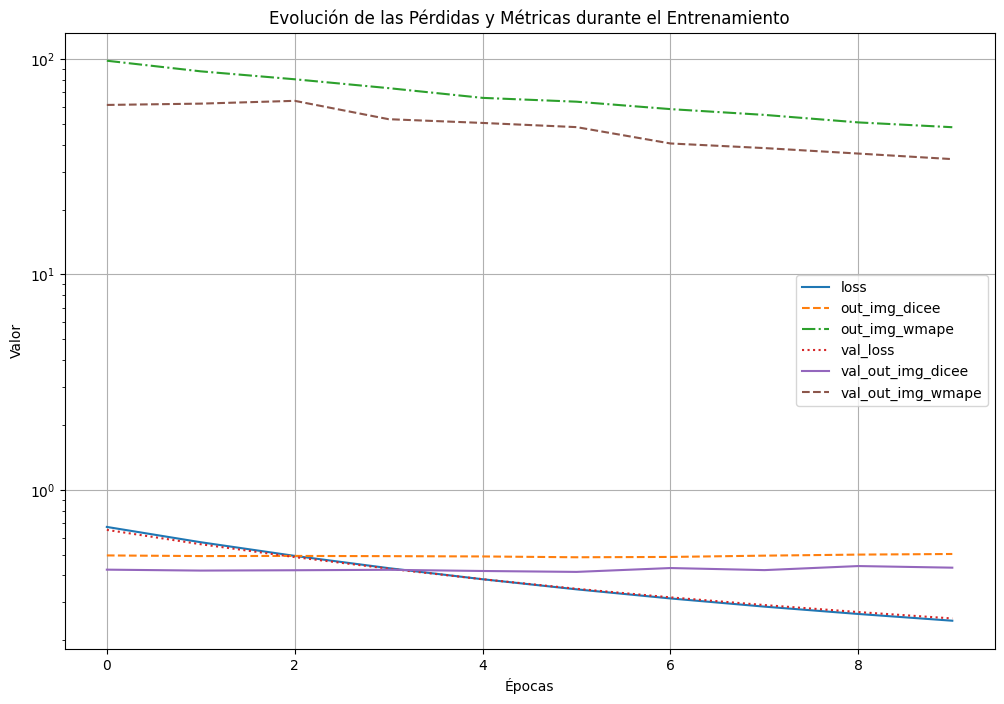

In [100]:
import matplotlib.pyplot as plt
import numpy as np


def plot_history(history):
	# Crear una figura
	plt.figure(figsize=(12, 8))

	line_styles = ['-', '--', '-.', ':']
	for i, key in enumerate(history.history.keys()):
		plt.plot(history.history[key], label=key, linestyle=line_styles[i % len(line_styles)])  # Estilo de línea diferente

	plt.yscale('log')
	# Configurar los detalles de la gráfica
	plt.title('Evolución de las Pérdidas y Métricas durante el Entrenamiento')
	plt.xlabel('Épocas')
	plt.ylabel('Valor')
	plt.legend()
	plt.grid(True)
	plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(3, 128, 128, 1)


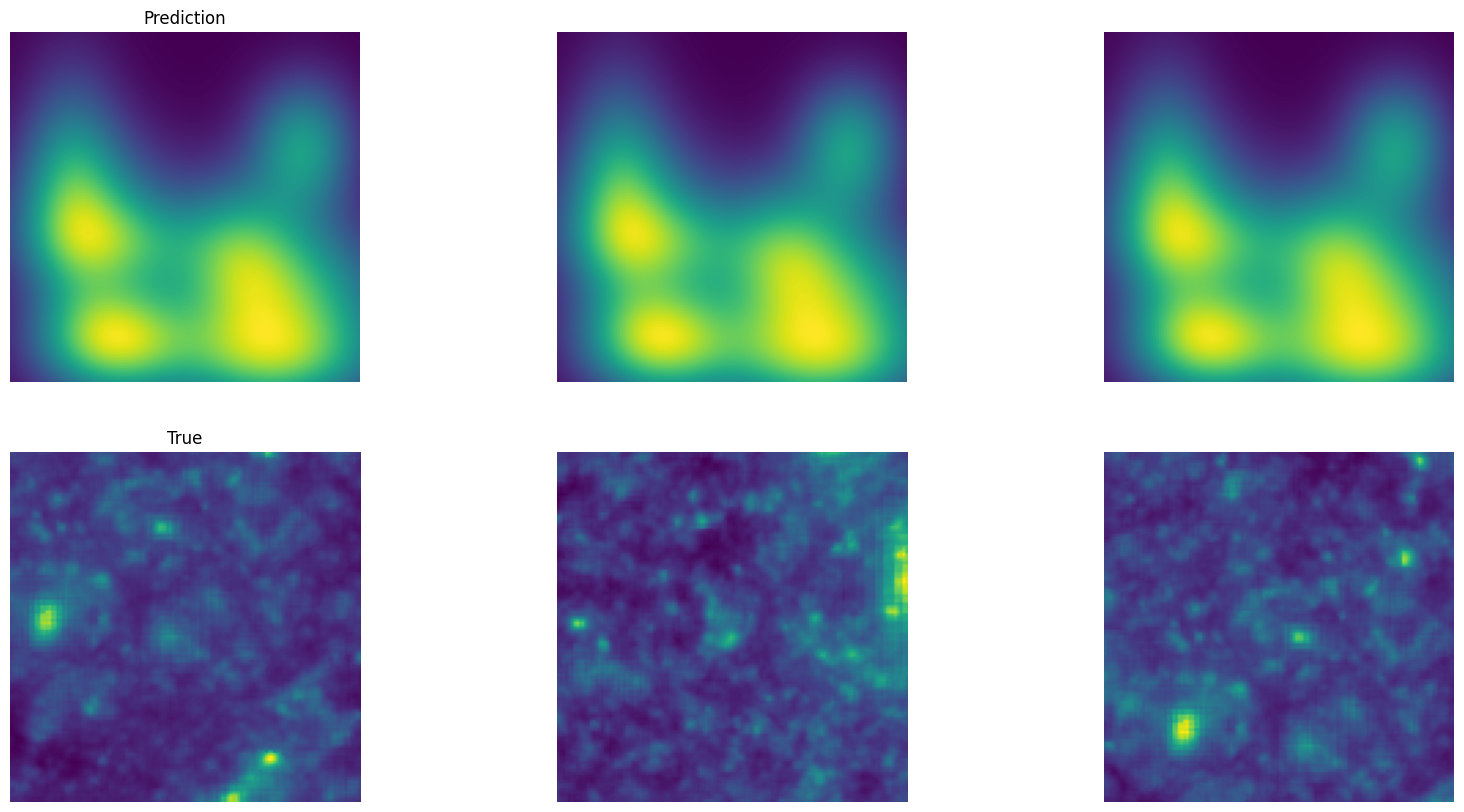

In [96]:
# es necesario especificar el numero de outputs de modelo siames
test_model_image(cnn_model, test_dataset, outs=2)

In [101]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=800, 
    home=home_data)
history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=True)


Using data folder: ..\data\1
Epoch 1/30
     17/Unknown 27s 1s/step - loss: 0.2551 - out_img_dicee: 0.5567 - out_img_wmape: 45.5516

C:\Users\fbien.DESKTOP-6FMEAR7\Documents\python\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.2540 - out_img_dicee: 0.5550 - out_img_wmape: 45.4194 - val_loss: 0.2364 - val_out_img_dicee: 0.4707 - val_out_img_wmape: 41.1738
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.2295 - out_img_dicee: 0.5621 - out_img_wmape: 42.4827 - val_loss: 0.2160 - val_out_img_dicee: 0.4760 - val_out_img_wmape: 37.8479
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2104 - out_img_dicee: 0.5675 - out_img_wmape: 39.0988 - val_loss: 0.1994 - val_out_img_dicee: 0.4814 - val_out_img_wmape: 34.9537
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1945 - out_img_dicee: 0.5748 - out_img_wmape: 36.8791 - val_loss: 0.1857 - val_out_img_dicee: 0.4850 - val_out_img_wmape: 32.4138
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.1814 - out_img_dicee: 0.5786 - out_img_wmape: 33.2199 - val_loss: 0.1741 - val_out_img_dicee: 0.4883 - val_out_img_wmape: 30.1670
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1

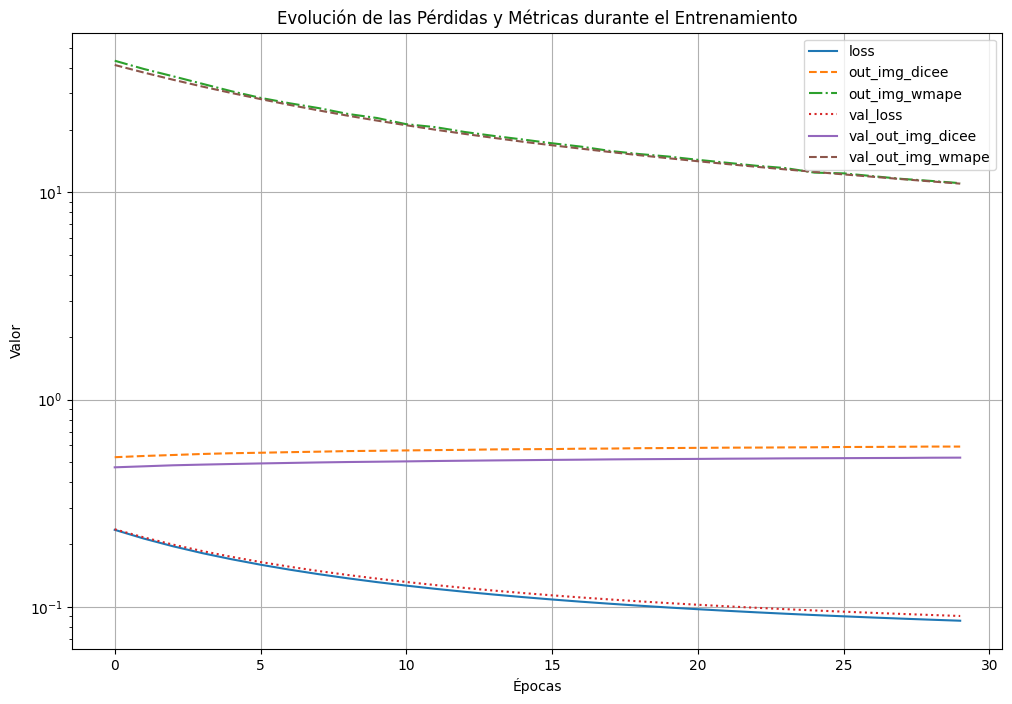

In [103]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
(3, 128, 128, 1)


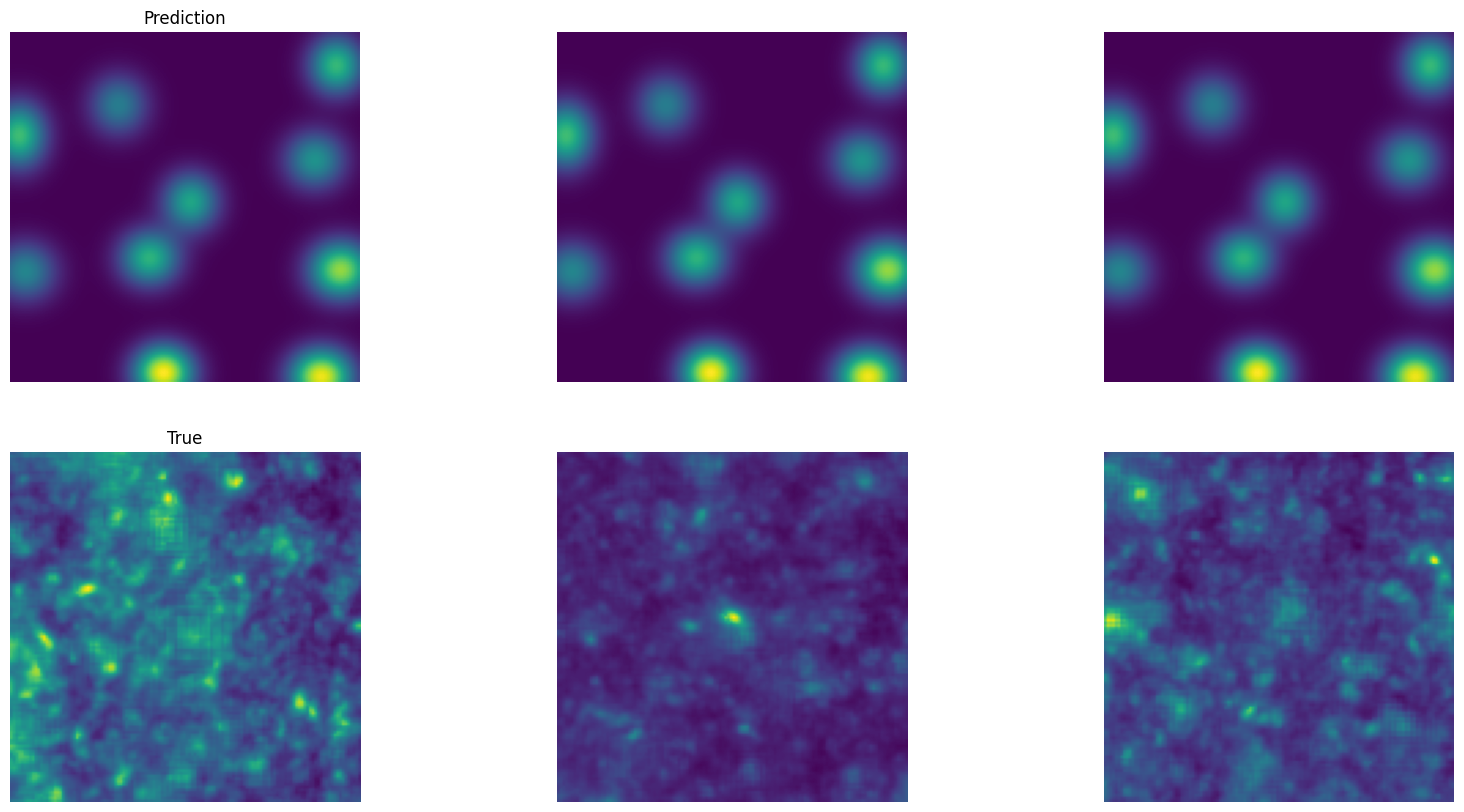

In [102]:
test_model_image(cnn_model, test_dataset, outs=2)

# Modelo con el doble de Ng

In [105]:

# Hiperparámetros como un diccionario
hyperparams = {
	'img_size': 128,               # Tamaño de la imagen de entrada
	'Ng': 30,                     # Número de Gaussianas (esto afecta el tamaño de salida)
	'num_conv_layers': 4,         # Número de capas convolucionales
	'conv_filters': 16,           # Número de filtros en cada capa convolucional
	'kernel_size': (4, 4),        # Tamaño del kernel
	'dense_units': 128,           # Número de unidades en las capas densas
	'num_dense_layers': 2,        # Número de capas densas
	'activation': 'tanh',         # Función de activación en las capas
	'output_activation': 'sigmoid',    # Sin activación final (los valores pueden ser negativos o positivos)
	'learning_rate': 0.0005        # Tasa de aprendizaje
}

# Crear el modelo utilizando el diccionario de hiperparámetros
cnn_model = create_cnn_model(hyperparams)

# Resumen del modelo
cnn_model.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 128, 128, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 128, 128, 16)   │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 64, 64, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 32, 32, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 16, 16, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 150)            │        19,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_img (GaussianImageLayer)    │ (None, 128, 128, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,294 (719.90 KB)

 Trainable params: 184,294 (719.90 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=900, 
    home=home_data)

Using data folder: ..\data\1


In [107]:
history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=True)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 13.7589 - out_img_dicee: 0.5538 - out_img_wmape: 736.1964 - val_loss: 4.5624 - val_out_img_dicee: 0.4756 - val_out_img_wmape: 280.4424
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 3.6291 - out_img_dicee: 0.5833 - out_img_wmape: 241.6180 - val_loss: 1.4938 - val_out_img_dicee: 0.5298 - val_out_img_wmape: 135.2612
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 1.2744 - out_img_dicee: 0.6037 - out_img_wmape: 139.2564 - val_loss: 0.7324 - val_out_img_dicee: 0.5019 - val_out_img_wmape: 83.5477
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.6863 - out_img_dicee: 0.5754 - out_img_wmape: 92.3691 - val_loss: 0.5172 - val_out_img_dicee: 0.5028 - val_out_img_wmape: 63.8355
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.5061 - out_img_dicee: 0.5764 - out_img_wmape: 68.9142 - val_loss: 0.4224 - val_out_img_dicee: 0.4976 - val_out_img_wmape: 53.5428
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s

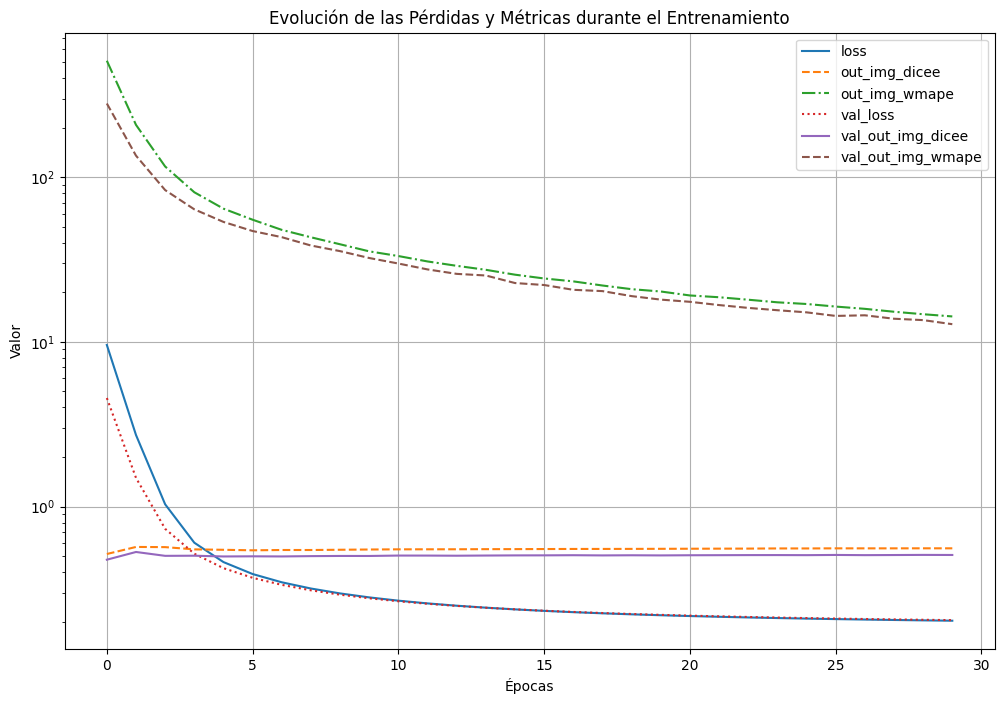

In [108]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
(3, 128, 128, 1)


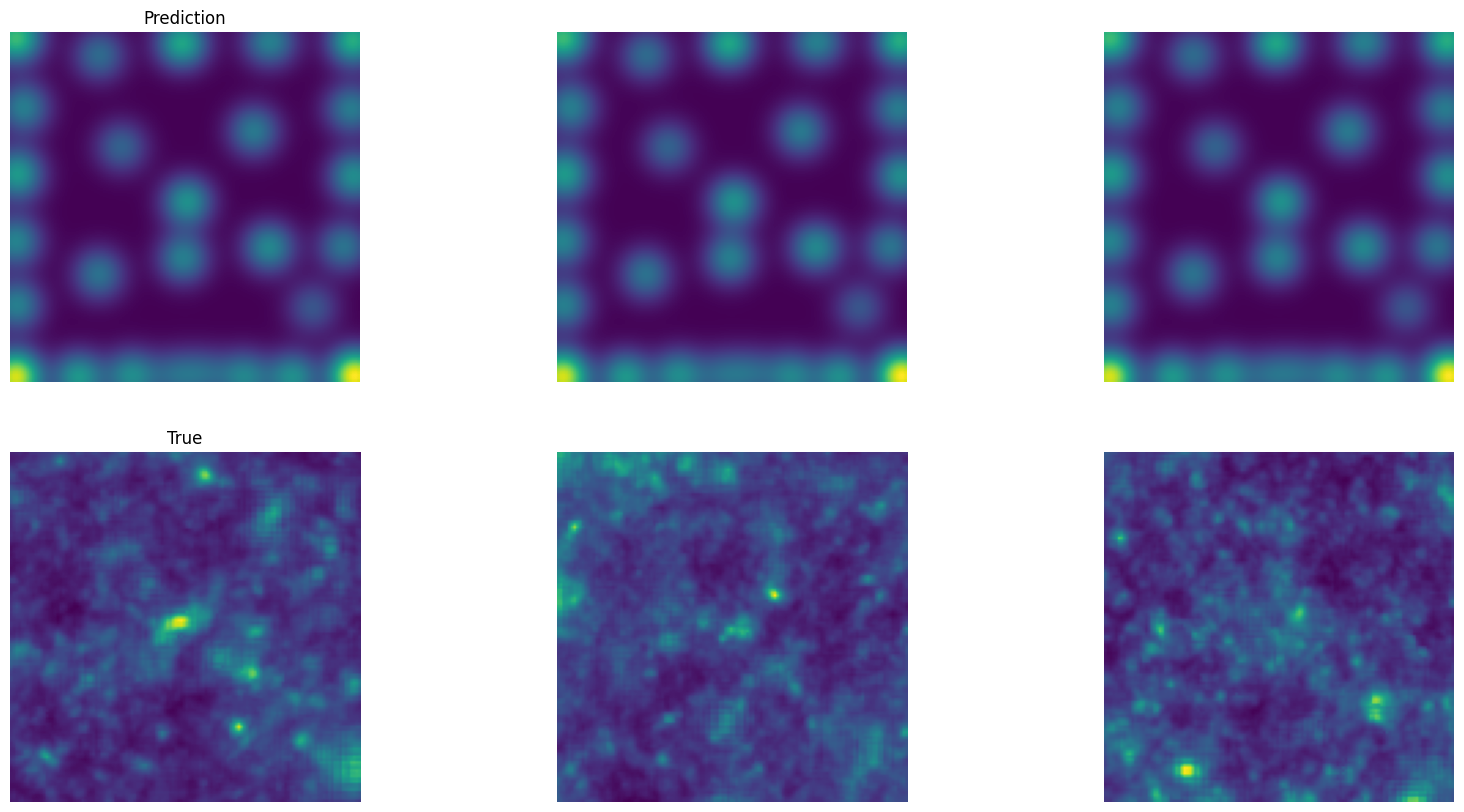

In [109]:
test_model_image(cnn_model, test_dataset, outs=2)